# Model training

In [ ]:
from pathlib import Path
from IPython.display import Audio
import torchaudio
import torchaudio.functional as taF
import torch.nn.functional as F
import torchaudio.transforms as T
from torch import tensor
from sounds.hits import data as D
from sounds.hits.data import *
from torch.utils.data import DataLoader, RandomSampler
import numpy as np

In [ ]:
#|export
from typing import Mapping
import torch, torch.nn as nn, torch.optim as optim
import torch.nn.functional as F
import math
import fastcore.all as fc
from fastprogress import master_bar, progress_bar

In [ ]:
#|default_exp hits.models

In [ ]:
sr = 16_000
xs = np.load('../data/train/dataset_x.npy')
ys = np.load('../data/train/dataset_y.npy')
valid_xs = np.load('../data/valid/dataset_x.npy')
valid_ys = np.load('../data/valid/dataset_y.npy')

In [ ]:
def augment_data(audio):
    if np.random.rand() < 0.5: 
        audio = T.Vol(gain=1.5)(audio)
    if np.random.rand() < 0.5: 
        audio = taF.add_noise(audio, torch.randn_like(audio)*0.5, snr = torch.randint(12, 30, ()))
    return audio

In [ ]:
from functools import partial

x_tfms = fc.Pipeline([tensor, T.Resample(new_freq=sr), T.MFCC(n_mfcc=64, melkwargs=dict(n_mels=64))])
y_tfms = [partial(tensor, dtype=torch.float32)]
train = D.TfmDataset(merge_items(xs, ys), x_tfms, y_tfms)
valid = D.TfmDataset(merge_items(valid_xs, valid_ys), x_tfms, y_tfms)

In [ ]:
dls = dataloaders(train, valid, batch_size=32, shuffle=True)

In [ ]:
xb,yb = next(iter(dls.train))

<matplotlib.colorbar.Colorbar>

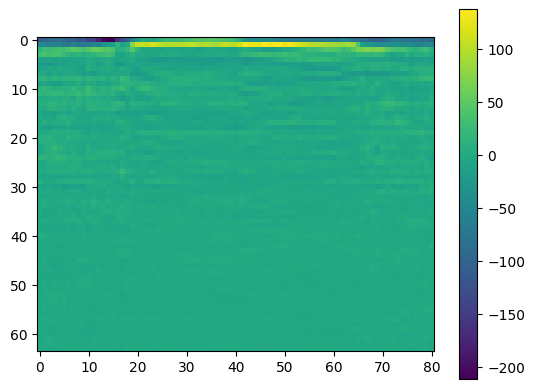

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(xb[0])
plt.colorbar()

# Model

In [ ]:
# |export
def tcsConv(n_in, n_out, k_size=3, stride=1, dilation=1, norm=True, act=None, pointwise=True):
    '''Time-Channel Separable Convolution'''
    if not pointwise: conv = nn.Sequential(nn.Conv1d(n_in, n_out, k_size,stride=stride, dilation=dilation))
    else:
        depthwise = nn.Conv1d(n_in, n_in, k_size, groups=n_in, dilation=dilation, padding='same')
        pointwise = nn.Conv1d(n_in, n_out, 1)
        conv = nn.Sequential(depthwise, pointwise)
    if norm: conv.append(nn.BatchNorm1d(n_out))
    if act: conv.append(act)
    return conv


class TCSBlock(nn.Module):
    '''Block from http://arxiv.org/abs/2004.08531'''

    def __init__(self, n_in, n_out, k_size):
        super().__init__()
        self.n_in = n_in
        self.n_out = n_out
        self.k_size = k_size
        self.tcs_conv = tcsConv(self.n_in, self.n_out, self.k_size)
        self.dropout = nn.Dropout()

    def forward(self, x, residual=None):
        x = self.tcs_conv(x)
        if residual is not None: x = x + residual
        x = F.relu(x)
        x = self.dropout(x)
        return x


class MainBlock(nn.Module):
    def __init__(self, n_in, n_out, k_size, R=1):
        super().__init__()
        self.n_in = n_in
        self.n_out = n_out
        self.k_size = k_size
        self.R = R

        self.inner_blocks = nn.ModuleList([TCSBlock(self.n_in, self.n_out, self.k_size)])
        for _ in range(R-1):
            self.inner_blocks.append(
                TCSBlock(self.n_out, self.n_out, self.k_size))
        self.residual = tcsConv(self.n_in, self.n_out,
                                1, act=None, pointwise=False)

    def forward(self, x):
        res = self.residual(x)
        for i, block in enumerate(self.inner_blocks):
            if (i+1) == len(self.inner_blocks):
                x = block(x, res)
            else:
                x = block(x)
        return x


class MatchBoxNetwork(nn.Module):
    def __init__(self, n_in, C, B=3, R=2, n_classes=1, k_init=11):
        super().__init__()
        k_sizes = [k*2+k_init for k in range(1, B)]
        self.prologue = tcsConv(n_in, 128, k_init, stride=2,
                                act=nn.ReLU(), pointwise=False)

        self.blocks = nn.ModuleList([MainBlock(128, C, k_sizes[0], R)])
        for k in k_sizes[1:]:
            self.blocks.append(MainBlock(C, C, k, R))

        self.epilogue = nn.Sequential(
            tcsConv(C, 128, k_init, dilation=2, pointwise=False),
            tcsConv(128, 128, 1),
            tcsConv(128, n_classes, 1),
            nn.AdaptiveAvgPool1d(1))
    
    def forward(self, x):
        x = self.prologue(x)
        for block in self.blocks:
            x = block(x)
        x = self.epilogue(x).squeeze()
        return x

In [ ]:
from torcheval.metrics import BinaryAccuracy
from sounds.learner import *

In [ ]:
dls = dataloaders(train, valid, batch_size=64, shuffle=True)
model = MatchBoxNetwork(64, 64)
cbs = [DeviceCB(), MetricsCB(acc=BinaryAccuracy(threshold=torch.logit(tensor(0.5)))), ProgressCB()]
learn = Learner(dls,model, F.binary_cross_entropy_with_logits, opt_func=optim.Adam, cbs=cbs)

In [ ]:
learn.fit(3, lr=0.005)

acc,loss,epoch,train
0.992,0.276,0,train
1.000,0.208,0,eval
1.000,0.185,1,train
1.000,0.153,1,eval
1.000,0.135,2,train
1.000,0.110,2,eval


In [ ]:
torch.save(model, '../models/model.pth')

# Test

In [ ]:
import librosa

In [ ]:
model = torch.load('../models/model.pth')

In [ ]:
path = Path('../data/thanos_message.wav')
sr = 16_000
window_size_s = 1.0 # seconds
window_size = int(window_size_s*sr)
stride = int(0.7*sr)

In [ ]:
s, sr = librosa.load(path, sr=sr)

In [ ]:
frames = split_audio(s, window_size, stride=stride)
dl = DataLoader(D.TfmDataset(merge_items(frames, frames), x_tfms), batch_size=256)

In [ ]:
detected = []
for xb, yb in progress_bar(dl):
    with torch.no_grad():
        probs = F.sigmoid(model(to_device(xb))).cpu()
    detected += [(v,p.item()) for v,p in zip(yb,probs) if p>=0.7]

In [ ]:
Audio(torch.cat(list(fc.L(detected).map(lambda x: x[0]))), rate=sr)